In [26]:
## Get data

import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
from trajectory import rat_trajectory
from scipy.interpolate import interp1d

#Perameters
shape = 'Sqr'

# cell_name = f' C{cell_num:03}'
spk_filename = f'data/B6_8_1_{shape}_Spike.csv'
trc_filename = f'data/B6_8_1_{shape}_Trace.csv'

# Read the CSV file
df = pd.read_csv(trc_filename, header=None)

# Get cell numbers
cell_numbers = df.iloc[0].dropna().tolist()[1:]
trace_per_cell = {cell: [] for cell in cell_numbers}

# Get time data
time_data = [float(i) for i in df.iloc[2:, 0].tolist()]
start_time = time_data[0]
time_data = [time_data[i] - start_time for i in range(len(time_data))]

traj_time, x_pos, y_pos, head_dir, velocity = rat_trajectory(shape)


# get trace data from each cell + interpolate
for i in range(np.shape(df.iloc[2:])[1] - 1):
    cell_name = np.asarray(cell_numbers)[i]
    trace_data = [float(i) for i in df.iloc[2:, i+1].tolist()]
    time_interp = interp1d(time_data, trace_data)

    trace_data = time_interp(traj_time)
    trace_data = (trace_data - np.mean(trace_data)) / np.std(trace_data)
    trace_per_cell[cell_name] = trace_data.tolist()

/home/brian/anaconda3/envs/pytorch/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3550: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [27]:
# index = [4, 7, 18, 25, 29, 30, 31, 33, 37, 43, 51, 53, 54, 55, 60, 65, 66, 67, 9, 10, 13, 15, 21, 22, 23, 36, 38, 41, 42, 47, 52, 59, 61, 73]
index1 = [20, 24, 32, 40, 44, 45, 46, 50, 56, 58, 62, 63, 64, 68, 69, 71, 72, 75, 76, 4, 7, 18, 25, 29, 30, 31, 33, 37, 43, 51, 53, 54, 55, 60, 65, 66, 67]
index2 = [9, 10, 13, 15, 21, 22, 23, 36, 38, 41, 42, 47, 52, 59, 61, 73]

In [28]:
## NaN interpolation ##
# For x_pos
invalid_x_pos = np.isnan(x_pos)
x_pos_interp = x_pos.copy()
x_valid = np.where(~invalid_x_pos)[0]
x_pos_interp[invalid_x_pos] = np.interp(np.where(invalid_x_pos)[0], x_valid, x_pos[x_valid])

# For y_pos
invalid_y_pos = np.isnan(y_pos)
y_pos_interp = y_pos.copy()
y_valid = np.where(~invalid_y_pos)[0]
y_pos_interp[invalid_y_pos] = np.interp(np.where(invalid_y_pos)[0], y_valid, y_pos[y_valid])

# For HD
invalid_hd = np.isnan(head_dir)
hd_interp = head_dir.copy()
hd_valid = np.where(~invalid_hd)[0]
hd_interp[invalid_hd] = np.interp(np.where(invalid_hd)[0], hd_valid, head_dir[hd_valid])

# For vel
invalide_vel = np.isnan(velocity)
vel_interp = velocity.copy()
vel_valid = np.where(~invalide_vel)[0]
vel_interp[invalide_vel] = np.interp(np.where(invalide_vel)[0], vel_valid, velocity[vel_valid])

# Update the original arrays
x_pos = x_pos_interp
y_pos = y_pos_interp
head_dir = hd_interp
velocity = vel_interp

# discard index where velocity < threshold
threshold = 2
moving_idx = [i for i, x in enumerate(velocity) if x > threshold]


In [29]:
def find_nearest_time_index(spike_time, traj_time):
    return np.argmin(np.abs(np.array(traj_time) - spike_time))

total_trace = np.zeros((len(traj_time), len(cell_numbers)))

# Iterate through cells and their spike times
for i, cell in enumerate(cell_numbers):
    total_trace[:, i] = np.asarray(trace_per_cell[cell])

print(np.shape(total_trace))

(26989, 77)


In [30]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.collections import LineCollection

import cebra.datasets
import cebra
from cebra import CEBRA

In [31]:
max_iterations = 1000 #default is 5000.

In [32]:
if shape == 'Hex':
    # normalize
    x_pos = x_pos / 10
    y_pos = y_pos / 10

    # to radial coordinates
    x_pos_ori, y_pos_ori = x_pos, y_pos
    theta = np.arctan(x_pos / y_pos)
    rad = np.sqrt(x_pos ** 2 + y_pos ** 2)
    continuous_index = np.column_stack((rad, theta))

elif shape == 'Tri':
    d_left = np.abs(1.586 * x_pos - y_pos + 25.241) / 1.876
    d_right = np.abs(-1.846 * x_pos - y_pos + 24.462) / 2.103
    d_bottom = np.abs(-0.036 * x_pos - y_pos - 16.836) / 1.001

    #normalize
    d_left, d_right, d_bottom = d_left/10, d_right/10, d_bottom/10
    continuous_index = np.column_stack((d_left, d_right, d_bottom))

elif shape == 'Sqr':
    # normalize
    x_pos = x_pos / 10
    y_pos = y_pos / 10

    min_x = np.min(x_pos)
    max_x = np.max(x_pos)
    min_y = np.min(y_pos)
    max_y = np.max(y_pos)

    continuous_index = np.column_stack((x_pos-min_x, max_x-x_pos, y_pos-min_y, max_y-y_pos))

In [33]:
dist = np.sqrt((x_pos - (min_x + max_x)/2)**2 + (y_pos - (min_y + max_y)/2)**2)
threshold1 = np.percentile(dist, 30)
threshold2 = np.percentile(dist, 70)

traceidx1 = np.where(dist < threshold1)[0]
traceidx2 = np.where(dist > threshold2)[0]

total_trace1 = total_trace[traceidx1, :]
total_trace2 = total_trace[traceidx2, :]

print(np.shape(total_trace1), np.shape(total_trace2))

continuous_index1 = continuous_index[traceidx1, :]
continuous_index2 = continuous_index[traceidx2, :]

print(np.shape(continuous_index1), np.shape(continuous_index2))

(8097, 77) (8097, 77)
(8097, 4) (8097, 4)


In [34]:
neural1 = total_trace1[:, index1] #index at 2
neural2 = total_trace2[:, index2] #index at 2

In [35]:
cebra_posdir3_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature_mode = 'constant',
                        temperature=1.5,
                        min_temperature = 1e-1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid=False)

cebra_posdir8_model= CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature_mode = 'constant',
                        temperature=1.5,
                        min_temperature = 1e-1,
                        output_dimension=8,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid=False)

cebra_posdir16_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature_mode = 'constant',
                        temperature=1.5,
                        min_temperature = 1e-1,
                        output_dimension=16,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid=False)

cebra_posdir3_model.fit(neural1, continuous_index1)
cebra_posdir3_model.save("models/cebra_posdir3_model.pt")

cebra_posdir8_model.fit(neural1, continuous_index1)
cebra_posdir8_model.save("models/cebra_posdir8_model.pt")

cebra_posdir16_model.fit(neural1, continuous_index1)
cebra_posdir16_model.save("models/cebra_posdir16_model.pt")

pos: -0.5081 neg:  6.3342 total:  5.8261 temperature:  1.5000: 100%|██████████| 1000/1000 [00:26<00:00, 37.34it/s]
pos: -0.5118 neg:  6.3396 total:  5.8278 temperature:  1.5000: 100%|██████████| 1000/1000 [00:27<00:00, 36.72it/s]
pos: -0.5204 neg:  6.3353 total:  5.8149 temperature:  1.5000: 100%|██████████| 1000/1000 [00:27<00:00, 35.89it/s]


In [36]:
cebra_posdir3_model = cebra.CEBRA.load("models/cebra_posdir3_model.pt")
cebra_posdir3_1 = cebra_posdir3_model.transform(neural1)

cebra_posdir8_model = cebra.CEBRA.load("models/cebra_posdir8_model.pt")
cebra_posdir8_1 = cebra_posdir8_model.transform(neural1)

cebra_posdir16_model = cebra.CEBRA.load("models/cebra_posdir16_model.pt")
cebra_posdir16_1 = cebra_posdir16_model.transform(neural1)

In [37]:
cebra_posdir3_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature_mode = 'constant',
                        temperature=1.5,
                        min_temperature = 1e-1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid=False)

cebra_posdir8_model= CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature_mode = 'constant',
                        temperature=1.5,
                        min_temperature = 1e-1,
                        output_dimension=8,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid=False)

cebra_posdir16_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature_mode = 'constant',
                        temperature=1.5,
                        min_temperature = 1e-1,
                        output_dimension=16,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid=False)

cebra_posdir3_model.fit(neural2, continuous_index2)

cebra_posdir8_model.fit(neural2, continuous_index2)

cebra_posdir16_model.fit(neural2, continuous_index2)

cebra_posdir3_2 = cebra_posdir3_model.transform(neural2)
cebra_posdir8_2 = cebra_posdir8_model.transform(neural2)
cebra_posdir16_2 = cebra_posdir16_model.transform(neural2)

pos: -0.5457 neg:  6.3455 total:  5.7998 temperature:  1.5000: 100%|██████████| 1000/1000 [00:26<00:00, 37.72it/s]
pos: -0.5557 neg:  6.3448 total:  5.7891 temperature:  1.5000: 100%|██████████| 1000/1000 [00:28<00:00, 35.28it/s]
pos: -0.5200 neg:  6.3431 total:  5.8231 temperature:  1.5000: 100%|██████████| 1000/1000 [00:55<00:00, 17.97it/s]


In [38]:
# embedding_labels = np.exp(np.minimum(np.minimum(continuous_index[:, 0], continuous_index[:, 1]), np.minimum(continuous_index[:, 2], continuous_index[:, 3])))
# norm = plt.Normalize(embedding_labels.min(), embedding_labels.max())
# normalized_index = norm(embedding_labels)

# dist_from_center = np.sqrt(((max_x + min_x)/2 - x_pos)**2 + ((max_y + min_y)/2 - y_pos)**2)
# norm = plt.Normalize(dist_from_center.min(), dist_from_center.max())
# normalized_index = norm(dist_from_center)

# # Choose colormap ('cool' or 'viridis')
# cmap = plt.get_cmap('plasma')  # or 'viridis'

# # Get RGB values (0-1 range)
# colors_float = cmap(normalized_index)[:, :3]

# # Convert to 0-255 range for PLY file
# colors = (colors_float * 255).astype(int)
# colors1 = colors[higher_pop1]
# colors2 = colors[higher_pop2]
# colors_uint8 = np.concatenate([colors1, colors2])

blue = np.array([0, 0, 1])  # RGB for blue
orange = np.array([1, 0.5, 0])  # RGB for orange

# Create color array
colors = np.zeros((len(cebra_posdir3_1) + len(cebra_posdir3_2), 3))
colors[:len(cebra_posdir3_1)] = blue
colors[len(cebra_posdir3_2):] = orange

# If you need the colors as uint8 (0-255 range) for some visualizations:
colors_uint8 = (colors * 255).astype(np.uint8)

# Function to write colored PLY file
def write_colored_ply(filename, points, colors):
    with open(filename, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {len(points)}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        for point, color in zip(points, colors):
            f.write(f"{point[0]} {point[1]} {point[2]} {color[0]} {color[1]} {color[2]}\n")

# Write the colored PLY file
dim = 3
write_colored_ply(f"embedding_3d_structures/colored_points_distance_{dim}_{shape}.ply", np.concatenate([cebra_posdir3_1, cebra_posdir3_2]), colors_uint8)
dim = 8
write_colored_ply(f"embedding_3d_structures/colored_points_distance_{dim}_{shape}.ply", np.concatenate([cebra_posdir8_1, cebra_posdir8_2]), colors_uint8)
dim = 16
write_colored_ply(f"embedding_3d_structures/colored_points_distance_{dim}_{shape}.ply", np.concatenate([cebra_posdir16_1, cebra_posdir16_2]), colors_uint8)

In [42]:
'''from matplotlib import pyplot as plt

# embedding_labels = (continuous_index[:, 0] < 0.2) & (continuous_index[:, 3] < 0.2)
embedding_labels = continuous_index[:, 1]

fig = plt.figure(figsize = (10,3), dpi = 100)
ax1 = plt.subplot(131,projection='3d')
ax1 = cebra.plot_embedding(ax=ax1, embedding=cebra_posdir3[:,:], embedding_labels=embedding_labels, cmap="cool")
ax2 = plt.subplot(132,projection='3d')
ax2 = cebra.plot_embedding(ax=ax2, embedding=cebra_posdir8[:,:], embedding_labels=embedding_labels, cmap="cool")
ax3 = plt.subplot(133,projection='3d')
ax3 = cebra.plot_embedding(ax=ax3, embedding=cebra_posdir16[:,:], embedding_labels=embedding_labels, cmap="cool")

ax1.set_title('CEBRA-Dim 3')
ax2.set_title('CEBRA-Dim 8')
ax3.set_title('CEBRA-Dim 16')
plt.savefig('./Figures-cebra/0722_Tri_trace_both_timelag')
plt.show()'''

'from matplotlib import pyplot as plt\n\n# embedding_labels = (continuous_index[:, 0] < 0.2) & (continuous_index[:, 3] < 0.2)\nembedding_labels = continuous_index[:, 1]\n\nfig = plt.figure(figsize = (10,3), dpi = 100)\nax1 = plt.subplot(131,projection=\'3d\')\nax1 = cebra.plot_embedding(ax=ax1, embedding=cebra_posdir3[:,:], embedding_labels=embedding_labels, cmap="cool")\nax2 = plt.subplot(132,projection=\'3d\')\nax2 = cebra.plot_embedding(ax=ax2, embedding=cebra_posdir8[:,:], embedding_labels=embedding_labels, cmap="cool")\nax3 = plt.subplot(133,projection=\'3d\')\nax3 = cebra.plot_embedding(ax=ax3, embedding=cebra_posdir16[:,:], embedding_labels=embedding_labels, cmap="cool")\n\nax1.set_title(\'CEBRA-Dim 3\')\nax2.set_title(\'CEBRA-Dim 8\')\nax3.set_title(\'CEBRA-Dim 16\')\nplt.savefig(\'./Figures-cebra/0722_Tri_trace_both_timelag\')\nplt.show()'

In [39]:
shuffled_index = np.random.permutation(continuous_index1)
# index = (5, 46) #30, 41, 46, 50, 67, 70
# neural = total_trace[:, index] # 78, 50, 68, 84, 122, 133

shuffled_cebra_posdir3_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.5,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

shuffled_cebra_posdir8_model= CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.5,
                        output_dimension=8,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

shuffled_cebra_posdir16_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.5,
                        output_dimension=16,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

shuffled_cebra_posdir3_model.fit(neural1, shuffled_index)

shuffled_cebra_posdir8_model.fit(neural1, shuffled_index)

shuffled_cebra_posdir16_model.fit(neural1, shuffled_index)

shuffled_cebra_posdir3_1 = shuffled_cebra_posdir3_model.transform(neural1)

shuffled_cebra_posdir8_1 = shuffled_cebra_posdir8_model.transform(neural1)

shuffled_cebra_posdir16_1 = shuffled_cebra_posdir16_model.transform(neural1)

  0%|          | 0/1000 [00:00<?, ?it/s]

pos: -0.3788 neg:  6.5751 total:  6.1963 temperature:  1.5000: 100%|██████████| 1000/1000 [00:30<00:00, 33.33it/s]
pos: -0.3530 neg:  6.5214 total:  6.1683 temperature:  1.5000: 100%|██████████| 1000/1000 [00:31<00:00, 31.99it/s]
pos: -0.3232 neg:  6.4797 total:  6.1566 temperature:  1.5000: 100%|██████████| 1000/1000 [00:54<00:00, 18.38it/s]


In [40]:
# index = (5, 46) #30, 41, 46, 50, 67, 70
# neural = total_trace[:, index] # 78, 50, 68, 84, 122, 133
shuffled_index = np.random.permutation(continuous_index2)

shuffled_cebra_posdir3_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.5,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

shuffled_cebra_posdir8_model= CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.5,
                        output_dimension=8,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

shuffled_cebra_posdir16_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.5,
                        output_dimension=16,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

shuffled_cebra_posdir3_model.fit(neural2, shuffled_index)

shuffled_cebra_posdir8_model.fit(neural2, shuffled_index)

shuffled_cebra_posdir16_model.fit(neural2, shuffled_index)

shuffled_cebra_posdir3_2 = shuffled_cebra_posdir3_model.transform(neural2)

shuffled_cebra_posdir8_2 = shuffled_cebra_posdir8_model.transform(neural2)

shuffled_cebra_posdir16_2 = shuffled_cebra_posdir16_model.transform(neural2)

pos: -0.3854 neg:  6.5572 total:  6.1719 temperature:  1.5000: 100%|██████████| 1000/1000 [00:43<00:00, 22.83it/s]
pos: -0.3457 neg:  6.5030 total:  6.1572 temperature:  1.5000: 100%|██████████| 1000/1000 [00:29<00:00, 33.65it/s]
pos: -0.2937 neg:  6.4612 total:  6.1675 temperature:  1.5000: 100%|██████████| 1000/1000 [00:29<00:00, 33.58it/s]


In [81]:
# cebra_posdir3 = np.concatenate([cebra_posdir3_1, cebra_posdir3_2])
# cebra_posdir8 = np.concatenate([cebra_posdir8_1, cebra_posdir8_2])
# cebra_posdir16 = np.concatenate([cebra_posdir16_1, cebra_posdir16_2])

# shuffled_cebra_posdir3 = np.concatenate([shuffled_cebra_posdir3_1, shuffled_cebra_posdir3_2])
# shuffled_cebra_posdir8 = np.concatenate([shuffled_cebra_posdir8_1, shuffled_cebra_posdir8_2])
# shuffled_cebra_posdir16 = np.concatenate([shuffled_cebra_posdir16_1, shuffled_cebra_posdir16_2])

cebra_posdir3 = cebra_posdir3_1
cebra_posdir8 = cebra_posdir8_1
cebra_posdir16 = cebra_posdir16_1

shuffled_cebra_posdir3 = shuffled_cebra_posdir3_1
shuffled_cebra_posdir8 = shuffled_cebra_posdir8_1
shuffled_cebra_posdir16 = shuffled_cebra_posdir16_1

In [82]:
import ripser

maxdim=1 # set to 2 to compute up to H2. The computing time is considerably longer. 

np.random.seed(100)
random_idx=np.random.permutation(np.arange(len(cebra_posdir3)))[:1000]
topology_dimension = {}
for embedding in [cebra_posdir3, cebra_posdir8, cebra_posdir16]:
    ripser_output=ripser.ripser(embedding[random_idx], maxdim=maxdim, coeff=47)
    dimension = embedding.shape[1]
    topology_dimension[dimension] = ripser_output

In [83]:
np.random.seed(100)
topology_random_dimension = {}
for embedding in [shuffled_cebra_posdir3, shuffled_cebra_posdir8, shuffled_cebra_posdir16]:
    ripser_output=ripser.ripser(embedding[random_idx], maxdim=maxdim, coeff=47)
    dimension = embedding.shape[1]
    topology_random_dimension[dimension] = ripser_output

In [84]:
print(np.shape(np.asarray(topology_random_dimension[3]['dgms'][0])))

(1000, 2)


In [85]:
def plot_barcode(topology_result, maxdim):
    fig, axs = plt.subplots(maxdim+1, 1, sharex=True, figsize=(7, 8))
    axs[0].set_xlim(0,2)
    cocycle = ["Points", "Loops", "Voids"]
    for k in range(maxdim+1):
        bars = topology_result['dgms'][k]
        bars[bars == np.inf] = 2
        lc = (
            np.vstack(
                [
                    bars[:, 0],
                    np.arange(len(bars), dtype=int) * 6,
                    bars[:, 1],
                    np.arange(len(bars), dtype=int) * 6,
                ]
            )
            .swapaxes(1, 0)
            .reshape(-1, 2, 2)
        )
        line_segments = LineCollection(lc, linewidth=5, color="gray", alpha=0.5)
        axs[k].set_ylabel(cocycle[k], fontsize=20)
        if k == 0:
            axs[k].set_ylim(len(bars) * 6 - 120, len(bars) * 6)
        elif k == 1:
            axs[k].set_ylim(0, len(bars) * 3 - 30)
        elif k == 2:
            axs[k].set_ylim(0, len(bars) * 6 + 10)
        axs[k].add_collection(line_segments)
        axs[k].set_yticks([])
        if k == 2:
            axs[k].set_xticks(np.linspace(0, 2, 3), np
                              .linspace(0, 2, 3), fontsize=15)
            axs[k].set_xlabel("Lifespan", fontsize=20)
    
    return fig 

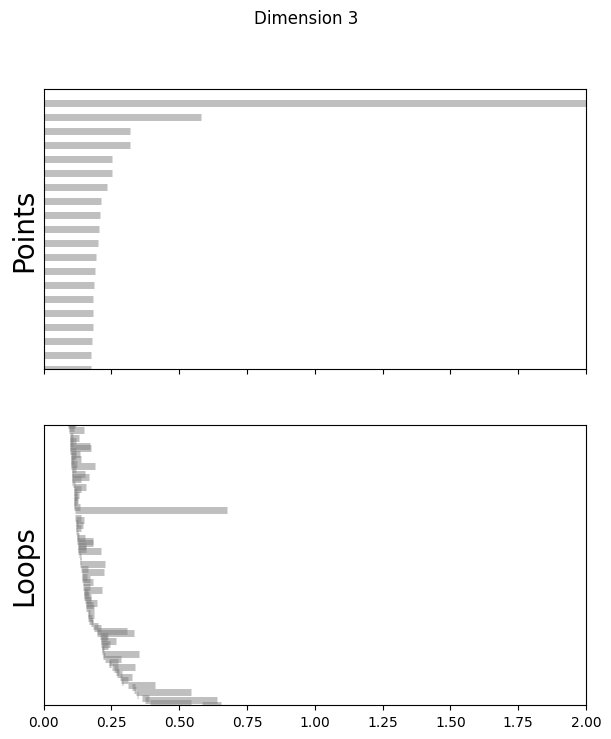

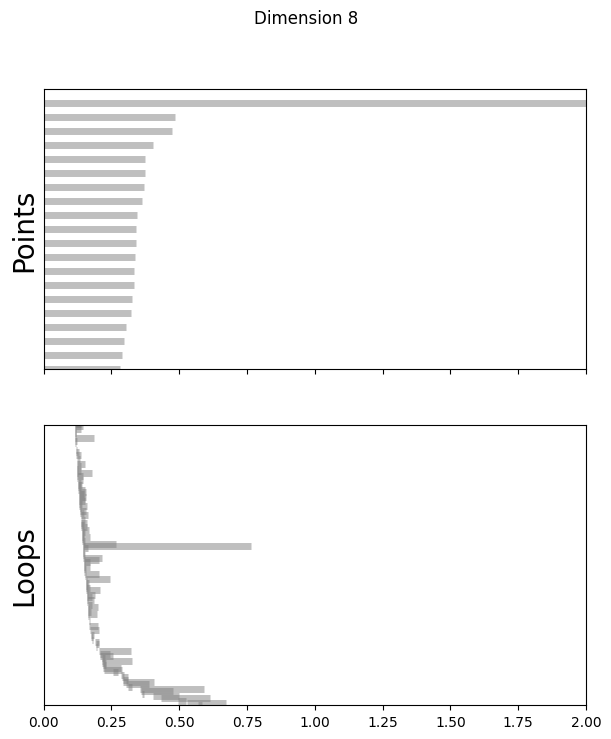

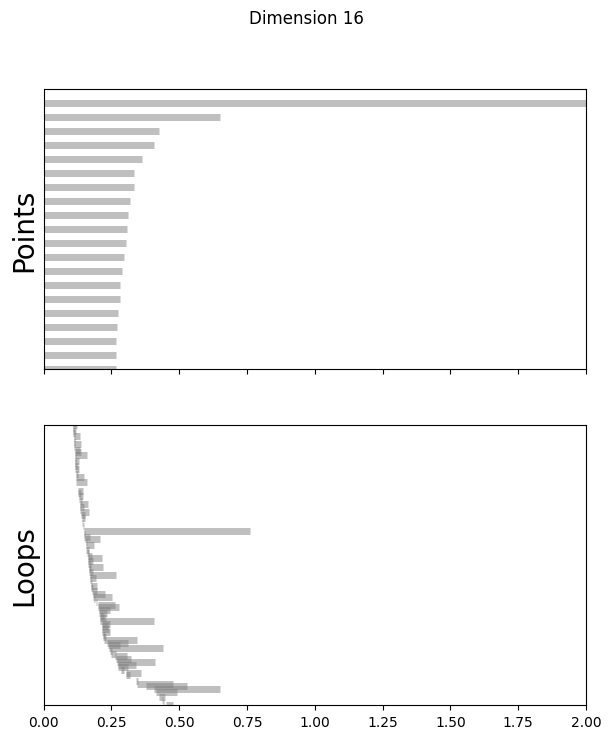

In [86]:
%matplotlib inline

for k in [3,8,16]:
    fig=plot_barcode(topology_dimension[k], maxdim)
    fig.suptitle(f'Dimension {k}')

In [87]:
np.shape(topology_random_dimension[3]['dgms'][0][:, 1])

(1000,)

In [88]:
topology_dimension[3]['num_edges']

398960

In [89]:
from persim import plot_diagrams

def read_lifespan(ripser_output, dim):
    dim_diff = ripser_output['dgms'][dim][:, 1] - ripser_output['dgms'][dim][:, 0]
    if dim == 0:
        return dim_diff[~np.isinf(dim_diff)]
    else:
        return dim_diff

def get_max_lifespan(ripser_output_list, maxdim):
    lifespan_dic = {i: [] for i in range(maxdim+1)}
    # for f in ripser_output_list:
    f = ripser_output_list
    for dim in range(maxdim+1):
        lifespan = read_lifespan(f, dim)
        lifespan_dic[dim].extend(lifespan)
    return [max(lifespan_dic[i]) for i in range(maxdim+1)], lifespan_dic

def get_betti_number(ripser_output, shuffled_max_lifespan):
    bettis=[]
    for dim in range(len(ripser_output['dgms'])):
        lifespans=ripser_output['dgms'][dim][:, 1] - ripser_output['dgms'][dim][:, 0]
        betti_d = sum(lifespans > shuffled_max_lifespan[dim] * 1.1)
        bettis.append(betti_d)
    return bettis

def plot_lifespan(topology_dgms, shuffled_max_lifespan, ax, label_vis, maxdim):
    plot_diagrams(
        topology_dgms,
        ax=ax,
        legend=True,
    )

    ax.plot(
        [
            -0.5,
            2,
        ],
        [-0.5 + shuffled_max_lifespan[0], 2 + shuffled_max_lifespan[0]],
        color="C0",
        linewidth=3,
        alpha=0.5,

    )
    ax.plot(
        [
            -0.5,
            2,
        ],
        [-0.5 + shuffled_max_lifespan[1], 2 + shuffled_max_lifespan[1]],
        color="orange",
        linewidth=3,
        alpha=0.5,

    )
    if maxdim == 2:
        ax.plot(
            [-0.50, 2],
            [-0.5 + shuffled_max_lifespan[2], 2 + shuffled_max_lifespan[2]],
            color="green",
            linewidth=3,
            alpha=0.5,
        )
    ax.set_xlabel("Birth", fontsize=15)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels([0, 1, 2])
    ax.tick_params(labelsize=13)
    if label_vis:
        ax.set_ylabel("Death", fontsize=15)
    else:
        ax.set_ylabel("")



Betti No. for dimension 3: [1, 1]
Betti No. for dimension 8: [1, 1]
Betti No. for dimension 16: [1, 1]


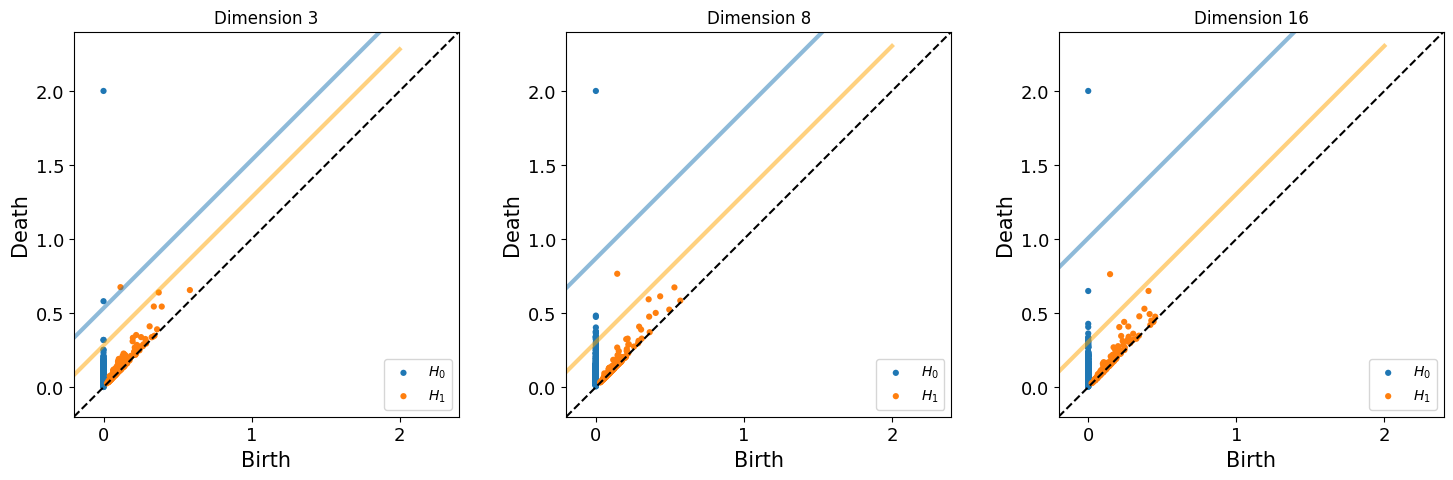

In [90]:
fig = plt.figure(figsize=(18,5))
for n, dim in enumerate([3,8,16]):
    shuffled_max_lifespan, lifespan_dic = get_max_lifespan(topology_random_dimension[dim], maxdim)
    ax = fig.add_subplot(1,3,n+1)
    ax.set_title(f'Dimension {dim}')
    plot_lifespan(topology_dimension[dim]['dgms'], shuffled_max_lifespan, ax, True, maxdim)
    print(f"Betti No. for dimension {dim}: {get_betti_number(topology_dimension[dim], shuffled_max_lifespan)}")